# Inferring Cluster Model Parameters from an X-ray Image

* Forward modeling is always instructive: we got a good sense of the parameters of our cluster + background model simply by generating mock data and visualizing it.


* The "inverse problem", also known as "inference," is to learn the parameters of an assumed model from a set of data. Intuitively we can see how it is going to work: try a lot of possible parameter combinations, and see which ones "match" the data.


* Our inability to guess parameter values accurately first time shows that we are *uncertain* about them. In Bayesian inference, we use probability distributions to describe this uncertainty mathematically.


* The sampling distribution ${\rm Pr}(d|\theta,H)$ encodes uncertainty about *what might have been,* given a model (or *hypothesis*) $H$ with parameters $\theta$. It allows us to generate mock datasets that are similar to the data that we do observe.


* Before we take any data, our uncertainty about our model parameter values is encoded in the *prior PDF* for the parameters given the model, ${\rm Pr}(\theta|H)$.


* Similarly, the sampling distribution ${\rm Pr}(d|\theta,H)$ can be thought of as the *prior over datasets* - a PDF could be imagined and used to generate mock data without us ever having seen any real data at all!

## Probability

* The idea of using probability distributions to quantify the uncertainty in our model parameters (and indeed in the models themselves) is due to Pierre Simon Laplace (1774), who rediscovered Thomas Bayes' earlier results on the probability of future events given their past history.


* [Let's remind ourselves how probabilities work](../../notes/ProbTheory.ipynb)


* Laplace and Bayes' key result is the following, usually referred to as "Bayes' Theorem:"

${\rm Pr}(\theta|d,H) = \frac{1}{{\rm Pr}(d|H)}\;{\rm Pr}(d|\theta,H)\;{\rm Pr}(\theta|H)$

What you know about your model parameters given the data is what you knew about them before $\left[ {\rm Pr}(\theta|H) \right]$, combined with what the data are telling you $\left[ {\rm Pr}(d|\theta,H) \right]$.


* ${\rm Pr}(\theta|d,H)$ is called the *posterior probability distribution* for the parameters given the data, *and is the general solution to the inverse problem.*


* Both the posterior and prior PDFs are functions of the model parameters. The sampling distribution is a function of the data given the parameters - when written as a function of $\theta$ it is called the *likelihood* of the parameters given the model.

## PGMs for Inverse Problems

* Here's the probabilistic graphical model for the inverse X-ray cluster model problem.

### Q: Spot the difference!

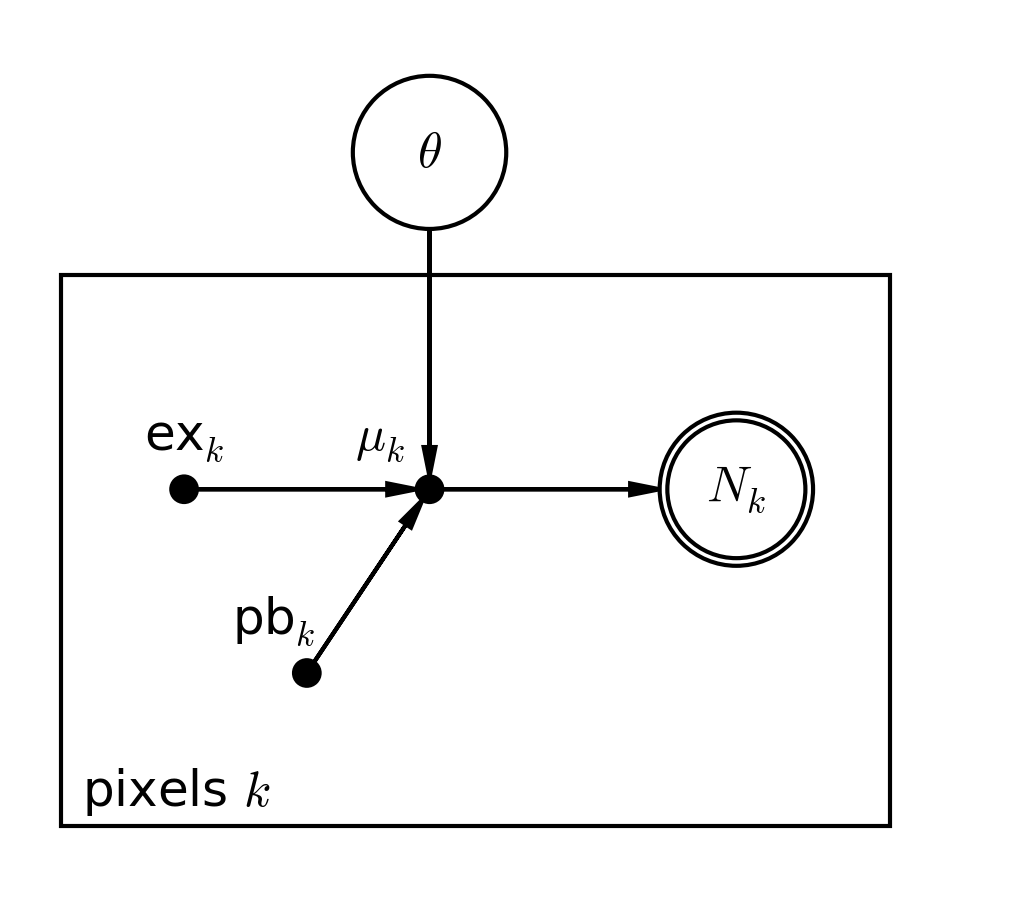

In [1]:
# import cluster_pgm
# cluster_pgm.inverse()

from IPython.display import Image
Image(filename="cluster_pgm_inverse.png")

This PGM illustrates the joint PDF for the parameters and the data, which can be factorised as:


$\prod_k \; {\rm Pr}(N_k\;|\;\mu_k(\theta),{\rm ex}_k,{\rm pb}_k,H) \; {\rm Pr}(\,\theta\,|H)$


It can also be factorised to:


${\rm Pr}(\,\theta\,|\{N_k\}\,H) \; {\rm Pr}(\{N_k\}\,|H)$


which is, up to the normalizing constant, the posterior PDF for the model parameters, given all the data $\{N_k\}$.


* PGMs can be used to *design inferences*

## Calculating Posterior PDFs

* Notice that the prior PDF ${\rm Pr}(\theta|H)$ and the likelihood function ${\rm Pr}(d|\theta,H)$ can typically be evaluated at any point in the parameter space.


* This means that we can always simply evaluate the posterior PDF on a grid (or at least attempt to), and normalize it by numerical integration.


* Let's do this for a simplified version of our X-ray cluster model.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import cluster

lets = cluster.XrayData()

lets.read_in_data()
lets.set_up_maps()

/Users/pjm/lsst/DarwinX86/anaconda/2.1.0-4-g35ca374/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [4]:
x0,y0 = 328,328    # The center of the image is 328,328
S0,b = 0.001,1e-6  # Cluster and background surface brightness, arbitrary units
beta = 2.0/3.0     # Canonical value is beta = 2/3
rc = 12            # Core radius, in pixels

logprob = lets.evaluate_unnormalised_log_posterior(x0,y0,S0,rc,beta,b)

In [5]:
print logprob

-28132.2655058


Good. Here's the code that is being run, inside the "XrayData" class:
```python
    def evaluate_log_prior(self):
        # Uniform in all parameters...
        return 0.0


    def evaluate_log_likelihood(self):
        self.make_mean_image()
        # Return un-normalized Poisson sampling distribution:
        # log (\mu^N e^{-\mu} / N!) = N log \mu - \mu + constant
        return np.sum(self.im * np.log(self.mu) - self.mu)


    def evaluate_unnormalised_log_posterior(self,x0,y0,S0,rc,beta,b):
        self.set_pars(x0,y0,S0,rc,beta,b)
        return self.evaluate_log_likelihood() + self.evaluate_log_prior()
```

Now let's try evaluating the 2D posterior PDF for cluster position, conditioned on reasonable values of the cluster and background flux, cluster size and beta:

In [6]:
import numpy as np

In [7]:
npix = 15
xmin,xmax = 327.7,328.3
ymin,ymax = 346.4,347.0

x0grid = np.linspace(xmin,xmax,npix)
y0grid = np.linspace(ymin,ymax,npix)
logprob = np.zeros([npix,npix])
for i,x0 in enumerate(x0grid):
    for j,y0 in enumerate(y0grid):
        logprob[j,i] = lets.evaluate_unnormalised_log_posterior(x0,y0,S0,rc,beta,b)
    print "Done column",i

Done column 0
Done column 1
Done column 2
Done column 3
Done column 4
Done column 5
Done column 6
Done column 7
Done column 8
Done column 9
Done column 10
Done column 11
Done column 12
Done column 13
Done column 14


In [8]:
print logprob[0:5,0]

[-4331.31567117 -4329.10284341 -4327.28054096 -4325.84891577 -4324.80810427]


To normalize this, we need to take care not to try and exponentiate any very large or small numbers...

In [9]:
Z = np.max(logprob)
prob = np.exp(logprob - Z)
norm = np.sum(prob)
prob /= norm

In [10]:
print prob[0:5,0]

[  5.26903048e-08   4.81669999e-07   2.97965165e-06   1.24713198e-05
   3.53127149e-05]


Let's plot this as a 2D probability density map.

In [11]:
import astropy.visualization as viz
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)

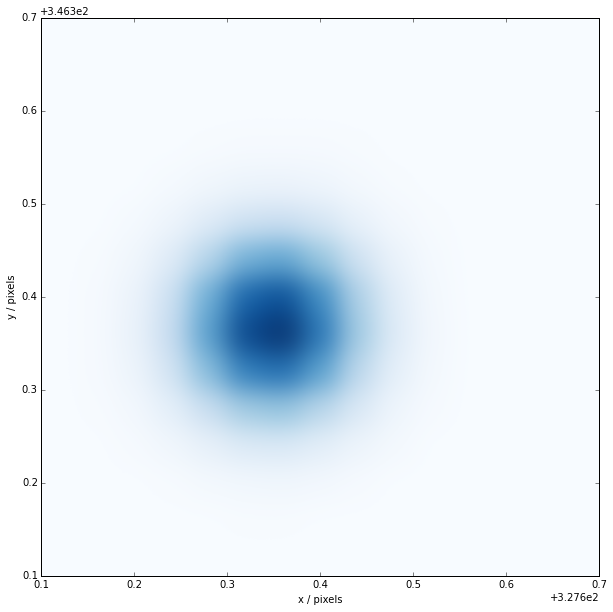

In [12]:
plt.imshow(prob, origin='lower', cmap='Blues', interpolation='gaussian', extent=[xmin,xmax,ymin,ymax])
plt.xlabel('x / pixels')
plt.ylabel('y / pixels')

* The above figure captures and illustrate our uncertainty about the position of the cluster center, given our model (and its assumptions), and our assertions about the values of the other parameters.


* To fully account for our uncertainty we should allow all model parameters to vary, and compute the 6D posterior PDF. As you can see, this will be time consuming! In sessions 3 and 4 we will look at ways to do these calculations far more efficiently.
